# North Carolina Litigation Predictor
# Final Preprocessing and Modeling<br><br>
# ADDRESS CLASS IMBALANCE - MIGHT BE CAUSE OF SHITTY AUC
# TRY USING SMOTE_NC FOR CLASS IMBALANCE


### Contents:
<ul>
    <li> Import Libraries
    <li> Final Preprocessing / One-Hot Encoding
    <li> Model Creation
        


## Import Libraries & Data

In [92]:
import io
import pandas as pd
import pickle

from imblearn.over_sampling import SMOTE#, SMOTE_NC
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import model_selection, naive_bayes, svm
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, auc

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [93]:
# Open the dataframe
infile = open('ProjectData/df_features.data', 'rb')
df = pickle.load(infile)
infile.close()

### Review and Clean DataFrame of Unneeded Columns

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2664 entries, 0 to 2663
Data columns (total 9 columns):
Opinion                 2664 non-null object
SCT                     2664 non-null int64
Year_Filed              2664 non-null int64
File_Numbers            2664 non-null object
Result                  2664 non-null int64
Case_Type               2664 non-null object
Case_Type_Confidence    2664 non-null object
Trial_Judge             2664 non-null object
County                  2664 non-null object
dtypes: int64(3), object(6)
memory usage: 187.4+ KB


In [95]:
df.drop(['Opinion', 'SCT', 'File_Numbers', 'Case_Type_Confidence', 'Year_Filed', 'County', 'Case_Type'], axis=1, inplace=True)

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2664 entries, 0 to 2663
Data columns (total 2 columns):
Result         2664 non-null int64
Trial_Judge    2664 non-null object
dtypes: int64(1), object(1)
memory usage: 41.8+ KB


In [97]:
df.isna().any()

Result         False
Trial_Judge    False
dtype: bool

In [98]:
df.shape

(2664, 2)

### One-Hot Encoding and Train/Test Split

In [99]:
y = df.Result
X = df.drop(columns = ['Result'])

In [100]:
# Either/Or of the following two:
X_gd = pd.get_dummies(X)
ohe = OneHotEncoder(handle_unknown='ignore')
X_ohe = ohe.fit_transform(X)

In [101]:
ohe.get_feature_names(X.columns)
# X.columns

array(["Trial_Judge_['abernathy', 'g.']",
       "Trial_Judge_['abernethy', 'richard ']",
       "Trial_Judge_['abernethy', 'richard']",
       "Trial_Judge_['adams', 'gale ']", "Trial_Judge_['adams', 'gale']",
       "Trial_Judge_['adkins', 'karl']", "Trial_Judge_['albright', 'r.']",
       "Trial_Judge_['albright', 'robert ']",
       "Trial_Judge_['albright', 'stuart']",
       "Trial_Judge_['albright', 'w.']", "Trial_Judge_['albright']",
       "Trial_Judge_['aldridge', 'thomas ']",
       "Trial_Judge_['alexander', 'karen ']",
       "Trial_Judge_['alford', 'benjamin ']",
       "Trial_Judge_['alford', 'benjamin']",
       "Trial_Judge_['allen', 'j.']", "Trial_Judge_['allen', 'philip ']",
       "Trial_Judge_['allen', 'stanley ']", "Trial_Judge_['allen', 'w.']",
       "Trial_Judge_['allsbrook', 'richard ']",
       "Trial_Judge_['ammons', 'james ']",
       "Trial_Judge_['anderson', 'charles']",
       "Trial_Judge_['arguments', 'panel']",
       "Trial_Judge_['baddour', 'allen']

In [102]:
X_gd.shape, X_ohe.shape

((2664, 560), (2664, 560))

In [103]:
# View class imbalance
y.value_counts()

1    1983
0     681
Name: Result, dtype: int64

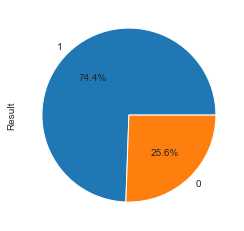

In [104]:
#Visualize class imbalance
y.value_counts().plot.pie(autopct="%.1f%%")

In [105]:
# USING X_ohe - SWITCH OUT IF DESIRED
X_train, X_test, y_train, y_test = train_test_split(X_ohe,y,random_state = 42, test_size = 0.3)

In [106]:
sm = SMOTE(sampling_strategy='auto', k_neighbors=2, random_state=42)
X_train ,y_train = sm.fit_resample(X_train, y_train) 

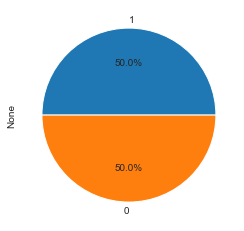

In [107]:
pd.Series(y_train).value_counts().plot.pie(autopct="%.1f%%");

## Modeling

Some research into the best probabilistic classification models suggests that logistic regression, SVMs, and neural networks would be the best fit for the intended goal.  I will run each on the data and see which performs best. 

### Logistic Regression Model

In [108]:
def auc_chart(fpr,tpr):
    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
    # Plot the ROC curve
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [109]:
def logreg_fn(X_train, X_test, y_train, y_test, params):
    logreg_clf = LogisticRegression(random_state=12)
    logreg_gs = GridSearchCV(logreg_clf, params, cv=5)
    logreg_gs.fit(X_train, y_train)
    best = logreg_gs.best_params_
    
    logreg_final = LogisticRegression(solver=best['solver'],
                                      penalty=best['penalty'],
                                      C=best['C'], 
                                      random_state=12)
    
    logreg_final.fit(X_train, y_train)
    y_hat = logreg_final.predict(X_test)
    y_score = logreg_final.decision_function(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    AUC = auc(fpr, tpr)

    print('Best params:',best,
          '\n Accuracy Score - Test: ', accuracy_score(y_test, y_hat),
          '\n Confusion Matrix:\n', confusion_matrix(y_test, y_hat), 
          '\n AUC: ', AUC)
    
    auc_chart(fpr,tpr)
    
    return()
    

Best params: {'C': 10, 'penalty': 'l2', 'solver': 'saga'} 
 Accuracy Score - Test:  0.56375 
 Confusion Matrix:
 [[ 65 128]
 [221 386]] 
 AUC:  0.5068586695802852


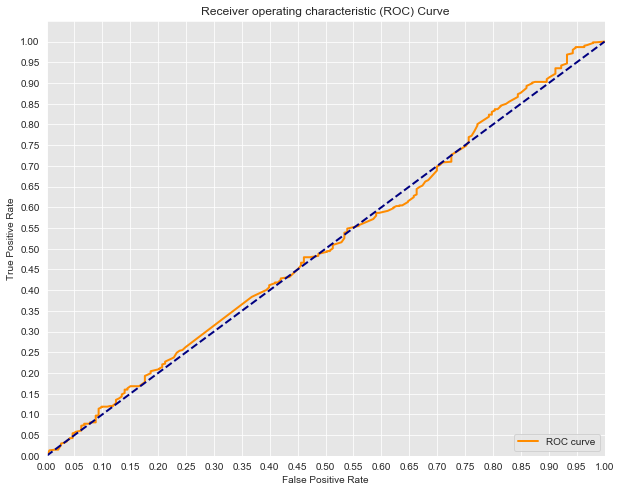

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.81 µs


In [110]:
parameters = {'C':[100,10,1,.1,.01], 
              'penalty':['l1', 'l2', 'elasticnet', 'none'],
              'solver':['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']}

logreg_fn(X_train, X_test, y_train, y_test, parameters)
%time

AUC is NOT GOOD!  The plot is nearly clinging to the 50% line.  
Accuracy is decent, but per the AUC, it's because the model is predicting almost everything as "reversed." 

<br>**Dropped Year_Filed: there's no reason this should be an input, resulted in better performance time-wise, but AUC still is dismal:**<br>
Best params: {'C': 100, 'penalty': 'none', 'solver': 'lbfgs'} <br>
 Accuracy Score - Test:  0.6225 <br>
 Confusion Matrix: <br>
 [[ 59 134]<br>
 [168 439]] <br>
 AUC:  0.5017882903261602
 <br>**Predicted on Trial_Judge and Case_Type:**<br>
 Best params: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'} <br>
 Accuracy Score - Test:  0.62375 <br>
 Confusion Matrix:<br>
 [[ 54 139]<br>
 [162 445]] <br>
 AUC:  0.5018565782622427<br>
 **Predicting on Case_Type Only:**<br>
 Best params: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'} <br>
 Accuracy Score - Test:  0.57375 <br>
 Confusion Matrix:<br>
 [[ 74 119]<br>
 [222 385]] <br>
 AUC:  0.5219631074425314<br>
 **Predicting on Trial_Judge Only:**<br>
 Best params: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}  <br>
 Accuracy Score - Test:  0.56375  <br>
 Confusion Matrix: <br>
 [[ 65 128] <br>
 [221 386]]  <br>
 AUC:  0.5068586695802852 <br>

### SVM Model

In [111]:
def svm_classifier(X_train, X_test, y_train, y_test, params):
    """
    Takes in train-test-split for X,y;
    Runs GridSearchCV and then uses the 
    best parameters to run an SVM model
    and returns an Accuracy Score and
    F1 Score.
    """
    clf_svm = svm.SVC(random_state=42)

    gs_svm = GridSearchCV(clf_svm, params, cv=5)
    gs_svm.fit(X_train,y_train)
    best = gs_svm.best_params_
    SVM = svm.SVC(C=best['C'], 
                  kernel=best['kernel'], 
                  degree=best['degree'], 
                  gamma=best['gamma'], 
                  random_state=42)
    SVM.fit(X_train,y_train)
    y_hat = SVM.predict(X_test)
    #print('SVM best params:',best)
    
    y_hat = SVM.predict(X_test)
    y_score = SVM.decision_function(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    AUC = auc(fpr, tpr)

    print('Best params:',best,
          '\n Accuracy Score - Test: ', accuracy_score(y_test, y_hat),
          '\n Confusion Matrix:\n', confusion_matrix(y_test, y_hat), 
          '\n AUC: ', AUC)
    
    auc_chart(fpr,tpr)
    return (round(accuracy_score(y_test, y_hat)*100,3), round(f1_score(y_test, y_hat, average='macro')*100,3))

Best params: {'C': 10, 'degree': 3, 'gamma': 1, 'kernel': 'rbf'} 
 Accuracy Score - Test:  0.5825 
 Confusion Matrix:
 [[ 62 131]
 [203 404]] 
 AUC:  0.4817073691219024


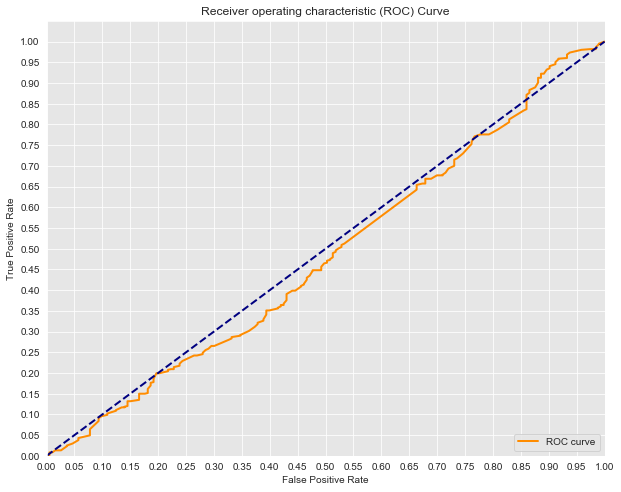

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [112]:
param_grid = {'C': [1,10],  
              'gamma': [1,.01], 
              'kernel': ['rbf', 'linear', 'sigmoid', 'poly'],
              'degree': [3,4]}

svm_classifier(X_train, X_test, y_train, y_test, param_grid)

%time

**Dropped Year_Filed, got the following:** <br>
Best params: {'C': 1, 'degree': 3, 'gamma': 1, 'kernel': 'rbf'}  <br>
 Accuracy Score - Test:  0.75875  <br>
 Confusion Matrix: <br>
 [[  3 190] <br>
 [  3 604]]  <br>
 AUC:  0.5075415489411103<br>
 **Dropped Year_Filed and County, got the following:**<br>
 Best params: {'C': 1, 'degree': 3, 'gamma': 1, 'kernel': 'rbf'} <br>
 Accuracy Score - Test:  0.71625 <br>
 Confusion Matrix:<br>
 [[ 28 165]<br>
 [ 62 545]] <br>
 AUC:  0.5156080613908546<br>
 **Predicting on Case_Type Only:**<br>
 Best params: {'C': 10, 'degree': 3, 'gamma': 0.01, 'kernel': 'sigmoid'} <br>
 Accuracy Score - Test:  0.57375 <br>
 Confusion Matrix: <br>
 [[ 74 119]<br>
 [222 385]] <br>
 AUC:  0.5262481754317079<br>
 **Predicting on Trial_Judge Only:**<br>
 Best params: {'C': 10, 'degree': 3, 'gamma': 1, 'kernel': 'rbf'} <br>
 Accuracy Score - Test:  0.5825 <br>
 Confusion Matrix:<br>
 [[ 62 131]<br>
 [203 404]] <br>
 AUC:  0.4817073691219024<br>

### Neural Network

# create tagging and feature set 
# create models 
# create pipeline
# create dashboard


There are many great paid proxy providers like Smartproxy, Netnut, Highproxies, etc. that can be used when scraping and at least you will know that you will get high-quality services that are safe to use with lots of features and big pools of IPs that you can use.